In [ ]:
'''
Multiple (8) base and grid searched classification models were run on
1.	all the features provided
2.	top 10 selected features
3.	PCA with 8 components having 80% cumulative variance
'''

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.set_option('display.max_columns', 500)   # to display 500 columns
pd.set_option('display.max_rows', 500)      # to display 500 rows


from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, mean_squared_error, r2_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier              
                
from six import StringIO
from sklearn.tree import export_graphviz

plt.rc("figure", figsize=(9, 7))

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor


### Defining functions for various tasks - EDA, cleaning, feature seelction, PCA,
### modelling, Gridsearch, model evaluation

In [2]:
def load_file(file):
    df = pd.read_csv(file, delimiter=",", header=None )
    print(df.shape)
        
    return df

In [3]:
def Perform_EDA(df, target):
        
        print('Printing the column names: ')
        print('------------')
        print(df.columns)
        print(' ')
        
        print('Renaming the columns: ')
        print('------------')
        
        df.columns = ['age','sex','chest_pain','resting_bp','chol','fbs','restecg',
                      'thalach','exang','oldpeak','slope','ca','thal','heart_disease']
    
        print(df.columns)
        print(' ')
        
        print('Size of the DataFrame: ')
        print('------------')
        print('df.shape: ')
        print(df.shape)
        print(' ')
        
        print('Data types: ')
        print('------------')
        print('df.info: ')
        print(df.info())
        print(' ')
        
        print('Printing value counts for each variable: ')
        print('------------')
        print(df.nunique())
        print(' ')
        
        
        #print('Printing outcomes of target column: ')
        #print('------------')
        #print(df[target].value_counts())
        #print(' ')
        
        # Checking for Nulls
        print('Checking for Nulls')
        print('--------------')
        print(df.isnull().sum())
        print('--------------')
        print(' ')
    
        # Identifying outliers
        print('Data Statistics to identify skewness and outliers etc: ')
        print('------------')
        print('df.describe')
        print(df.describe(include='all')) 
        print(' ')
        
        return df

In [4]:
def targetVariableAdjustments(df, target):
    
    # Making the target variable binary, 0 when it was 0 and 1 when it was either 1,2,3,4
    df[target] = df[target].replace([1,2,3, 4],[1,1,1,1])
    
    return df

In [5]:
def plotting(df, target):
    # Box plots and Bar plots
    
    #binary_features = ['sex', 'fbs', 'exang'] # ,target
    categorical_features = ['sex', 'fbs', 'exang', 'chest_pain', 'restecg', 
                            'slope', 'ca', 'thal']
    continuous_features = ['age', 'resting_bp', 'chol',  'oldpeak', 'thalach']
    
    plt.figure(figsize=(15, 15))

    # Categorical Features plotting
    
     #df[categorical_features].plot(kind='bar', subplots=True, layout=(2,8),
      #      sharex=False,sharey=False, figsize=(20, 10) ); 
    
    for i, column in enumerate(categorical_features, 1):
        plt.subplot(2, 4, i)


        df[df[target] == 0][column].hist(bins=35, color='green', label='Heart_Disease = NO', alpha=0.5)
        df[df[target] == 1][column].hist(bins=35, color='red', label='Heart_Disease = YES', alpha=0.5)
        plt.legend()
        plt.xlabel(column)
    
    # Continuous Features plotting
    
    df[continuous_features].plot(kind='box', subplots=True, layout=(2,7),
    sharex=False,sharey=False, figsize=(20, 10) ); 
    
    return categorical_features, continuous_features


In [6]:
def DataCleaning(df):
    
        '''
        Steps:
        After close analysis of the features (esp Object type)

        1. TypeCasting object to int or float and removing any non-numeric characters
        
        2. TypeCasting float into int64 (except 'oldpeak' all the other features 
                looks int, so typecasting to save memory)
                
        3. Deleting Nulls (Not imputing as number of nulls are very small)

        4. drop duplicates, if any
        
        5. Removing outliers
            chol, oldpeak and thalac seems to have outliers. 
            limiting to within Q1 - 1.5IQR and Q3 + 1.5IQR range
        '''

     # 1. TypeCasting object to int or float
         # removes any ascii etc chars
        df['ca'] = pd.to_numeric(df['ca'], errors='coerce')
        df['thal'] = pd.to_numeric(df['thal'], errors='coerce')

        
     # 2  Tpecasting float to int #except 'oldpeak' 
        df[['sex', 'fbs', 'exang', 'chest_pain', 'restecg','slope', 'age',
            'resting_bp', 'chol', 'thalach']] = df[['sex', 'fbs', 'exang', 
                                                  'chest_pain', 'restecg','slope',
                                                  'age','resting_bp', 'chol', 
                                                  'thalach']].astype('int64')
       
                        
    # 3. Dropping Nans (or impute with mean, mode etc)
        df.dropna(inplace=True)
        
    # 4. Dropping duplicates, if any
        df.drop_duplicates(inplace = True)
    
    # 5. Removing outliers
    # chol, oldpeak and thalac seems to have outliers

        Q1 = np.percentile(df, 25, interpolation = 'midpoint')
        Q3 = np.percentile(df, 75, interpolation = 'midpoint') 
        
        IQR = Q3-Q1 # Interquartile Range
        
        lower_limits = Q1 - (IQR * 1.5)
        upper_limits = Q3 + (IQR * 1.5)
        
        df = df[~((df >= upper_limits) & (df <= lower_limits))]#.index.tolist()  
        
      # Checking for Nulls
        print('Checking for Nulls')
        print('--------------')
        print(df.isnull().sum())
        print('--------------')
        print(' ')
        
        
     # Checking for Outliers again
        #print('Checking for outliers')
        #print('--------------')
        #print(df.describe(include='all')) 
        #print('--------------')
        #print(' ')

        print('info: ')
        print(df.info())
        print('--------------')
        print(' ')

        print('shape: ')
        print(df.shape)

        return df

In [7]:
def DataVisualizations(df, target, categorical_features, continuous_features):
    
    # Plot distributions
       # 1. numerical_features = histogram
       # 2. pair plots
    
    # 1. Histograms
        
    plt.figure(figsize=(15, 15))
    
    for i, column in enumerate(continuous_features, 1):
        plt.subplot(2, 3, i)
        df[df[target] == 0][column].hist(bins=35, color='green', label='Heart_Disease->No', alpha=0.6)
        df[df[target] == 1][column].hist(bins=35, color='red', label='Heart_Disease->Yes', alpha=0.6)
        plt.legend()
        plt.xlabel(column)

    
    # 2. Visualizing the relationship between features (Hue for Outcome)

    sns.pairplot(data=df, vars=list(df.select_dtypes([np.number]).columns),
                       hue=target, height=3)
    plt.show()
    

In [92]:
def TrainTestSplit_Standardization(df, target, test_size):

        # Features 
        y = df[target]
        X = df[df.columns.difference([target])] # All columns excpet the target

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                            shuffle=True, stratify=y) 
        print(X_train.shape)
        print(y_train.shape)
        print(X_test.shape)
        print(y_test.shape)
        
        # Preserving for future use (bias evaluation)
        
        X_train_orig, X_test_orig, y_train_orig, y_test_orig = X_train, X_test, y_train, y_test

        # Standardize the data

        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        
        return X_train, X_test, y_train, y_test, X_train_orig, X_test_orig, y_train_orig, y_test_orig

In [9]:
def featureSelection(df, target, X_train, y_train):
    
    # Using the following measures to identify best features
    
    # 1. Correlation
    # 2. SelectKBest 
    # 3. VIF - to identify multicolinearity
    
    
    # 1. Correlation

        print('Plotting correlation')
        print('------------')
        
        corr = df.corr()

        fig, ax = plt.subplots(figsize=(20,12))
        matrix = np.triu(corr)
        ax = sns.heatmap(corr, annot = True, mask=matrix, center= 0, cmap="BuPu" ,fmt='.1g'); #cmap= 'coolwarm',    

        plt.show()
          
        
     # 2. selecting best features
        #from sklearn.feature_selection import SelectKBest, chi2, f_classif
        
        #X = df[df.columns.difference([target])] # All columns excpet the target
        
        print(' ')
        print('Plotting K-best features')
        print('------------')
        
        selector = SelectKBest(score_func=f_classif, k='all')# chi2  f_classif
        fit = selector.fit(X_train, y_train)
        scores = -np.log10(fit.pvalues_)
        scores /= scores.max()
        
        #X_indices = np.arange(X_train.shape[-1])
        
        #plt.bar(X_indices - .45, scores, width=.2,
         #       label=r'Score ($-Log(p_{value})$)')
    
        df_pvalues = pd.DataFrame(fit.pvalues_)
        df_scores = pd.DataFrame(fit.scores_)
        df_columns = pd.DataFrame(X_train.columns)
        
        # concatenate dataframes
        feature_scores = pd.concat([df_columns, df_scores, df_pvalues],axis=1)
        feature_scores.columns = ['Feature_Name','Score', 'p-values']  # name output columns
        print(feature_scores.nlargest(12,'Score'))
        
            
    # 3. VIF
        print(' ')
        print('Variation Inflation Factor')
        print('------------')
        
        #from statsmodels.stats.outliers_influence import variance_inflation_factor
              
        vif = pd.DataFrame()
        vif["Features"] = df.columns
        vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        print(vif.sort_values(by='VIF', ascending=False)) 
        

In [10]:
# Feature selection based on corealtion and SelectK features and VIF 
# (we select the variables with high VIF as collinear variables)

def selectedFeatures(X_train, X_test):
 # dropping  fbs, age, sex, chol, resting_bp, restecg
    
    X_train = X_train.drop(columns = ['fbs', 'chol', 'resting_bp'], axis = 1) #,'restecg'
    X_test = X_test.drop(columns = ['fbs', 'chol', 'resting_bp'], axis = 1)#, 'restecg'
    
    print('X_train: ', X_train.shape)
    print('X_test: ',X_test.shape)
    
    return X_train, X_test

In [11]:
def PCA(X_train, X_test):

    from sklearn.decomposition import PCA

    pca = PCA(n_components=8)  # 8 components have 80% variance

    X_train_pca = pca.fit_transform(X_train) # PCA fit-tranform on train data
    X_test_pca = pca.transform(X_test)       # PCA tranform on test data
    
    # Converting into DataFrame
    PCA_col_dict = {'PCA'+str(i+1): pca.components_[i]
                for i in range(len(pca.components_))}
    
    df_pca = pd.DataFrame(PCA_col_dict, index=X_train.columns) 
    
    X_train_pca = pd.DataFrame(X_train_pca, columns=PCA_col_dict) 
    #print(X_train_pca.shape)

    X_test_pca = pd.DataFrame(X_test_pca, columns=PCA_col_dict) 
    #print(X_test_pca.shape)
    
    explained_variance = pca.explained_variance_ratio_
    explained_variance.cumsum()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    x_values = list(range(1, pca.n_components_+1))
    ax.plot(x_values, explained_variance, lw=2)
    ax.scatter(x_values, explained_variance, s=120)
    ax.plot(x_values, np.cumsum(explained_variance), lw=2)
    ax.scatter(x_values, np.cumsum(explained_variance), s=120)

    ax.set_title('Explained variance pct\n', fontsize=20)
    ax.set_xlabel('Principal Component', fontsize=16)
    ax.set_ylabel('Variance Explained (%)', fontsize=16)
    plt.show()

    return df_pca, X_train_pca, X_test_pca

In [12]:
def baseModelFitting(classifiers, n_splits, X_train, X_test, y_train, y_test):
        
        fitted_classifiers = {} #[]
        
        for name, classifier in classifiers:
            
            classifier.fit(X_train, y_train)

            kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

            train_score = classifier.score(X_train, y_train)
            trainCV_score = cross_val_score(classifier, X_train, y_train, cv = kf).mean()
            test_score = classifier.score(X_test, y_test)

            print('Classifier: ', classifier)
            print(' ')
            
            # Classification report
            print('Classification report')
            predictions = classifier.predict(X_test)
            print(classification_report(y_test, predictions))
            
            print(' ')
            print('Confusion Matrix')
            
            labels=[0, 1]
            confusion_mat = confusion_matrix(y_test, predictions, labels=labels)
            

            confusion_mat = pd.DataFrame(confusion_mat,
             columns=['Predicted_No', 'Predicted_Yes'],
             index=  ['True_No', 'True_Yes'])
            
            print(confusion_mat)
            
            #print("Score(Train): ", train_score)
            #print("Cross Val Score (Train): ", trainCV_score) 
            #print("Score (Test): ", test_score)
            print('-------------------------------------------')
            
            #fitted_classifiers.append(classifier)
            fitted_classifiers[name] = classifier

        return fitted_classifiers
    

In [13]:
def gridSearchModelFitting(classifiers, grid_search_params, n_splits, X_train, X_test, y_train, y_test):
        
        # Storing the best estimator from each classifier
        best_gs_classifiers = {}
        
        for classifier, grid_search_param in zip(base_classifiers, grid_search_params):
            
            # Note classifier[0] is name and classifier[1] is the model
            
            kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

            gridsearchedClassifier = GridSearchCV(estimator=classifier[1],
                                             param_grid=grid_search_param,
                                             cv=kf,
                                             scoring='accuracy',  
                                             n_jobs=-1,                                  
                                             verbose=0,
                                             return_train_score=True,
                                             refit=True
                                            )
        
            gridsearchedClassifier.fit(X_train, y_train)
        
            gs_cv_score = cross_val_score(gridsearchedClassifier, X_train, y_train, cv=kf).mean()
            gs_best_test_score = gridsearchedClassifier.best_estimator_.score(X_test, y_test)

            print('Classifier: ', classifier[0])
            print("model cross val score: %.3f" % gs_cv_score)
            print("model best score: %.3f" % gridsearchedClassifier.best_score_)
            print("model test score: %.3f" % gs_best_test_score)
            print("----------------------")
        
            best_gs_classifiers[classifier[0]] = {
                     'Best Estimator': gridsearchedClassifier.best_estimator_,
                     'Best Score': gridsearchedClassifier.best_score_,
                     'Best test score' : gs_best_test_score,
                     'Best params': gridsearchedClassifier.best_params_
                    }   
        
        return best_gs_classifiers
        

### Running the functions

#### Loading file

In [86]:
file_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
#file_path = "processed.cleveland.data" 

# The file .data is comma delimited and doesnt have a header
heartDF = load_file(file_path) #pd.read_csv(file_path, delimiter=",", header=None)

(303, 14)


In [87]:
heartDF.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [88]:
target = "heart_disease"
heartDF = Perform_EDA(heartDF, target)

Printing the column names: 
------------
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')
 
Renaming the columns: 
------------
Index(['age', 'sex', 'chest_pain', 'resting_bp', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'heart_disease'],
      dtype='object')
 
Size of the DataFrame: 
------------
df.shape: 
(303, 14)
 
Data types: 
------------
df.info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age              303 non-null float64
sex              303 non-null float64
chest_pain       303 non-null float64
resting_bp       303 non-null float64
chol             303 non-null float64
fbs              303 non-null float64
restecg          303 non-null float64
thalach          303 non-null float64
exang            303 non-null float64
oldpeak          303 non-null float64
slope            303 non-null float64
ca               303 non-null object
thal         

In [89]:
# Since target have 5 values, so whenitevr its 0 we assign 0 which means no Heart disease,
# for values of 1,2,3,4 we assign 1, which means the patinet has heart disease.

heartDF = targetVariableAdjustments(heartDF, target)

In [90]:
print(heartDF.heart_disease.value_counts())
print('--------------------------------')
print('Baseline Accuracy')
print(heartDF.heart_disease.value_counts(normalize=True))
print('--------------------------------')
heartDF.head(2)

0    164
1    139
Name: heart_disease, dtype: int64
--------------------------------
Baseline Accuracy
0    0.541254
1    0.458746
Name: heart_disease, dtype: float64
--------------------------------


,age,sex,chest_pain,resting_bp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1


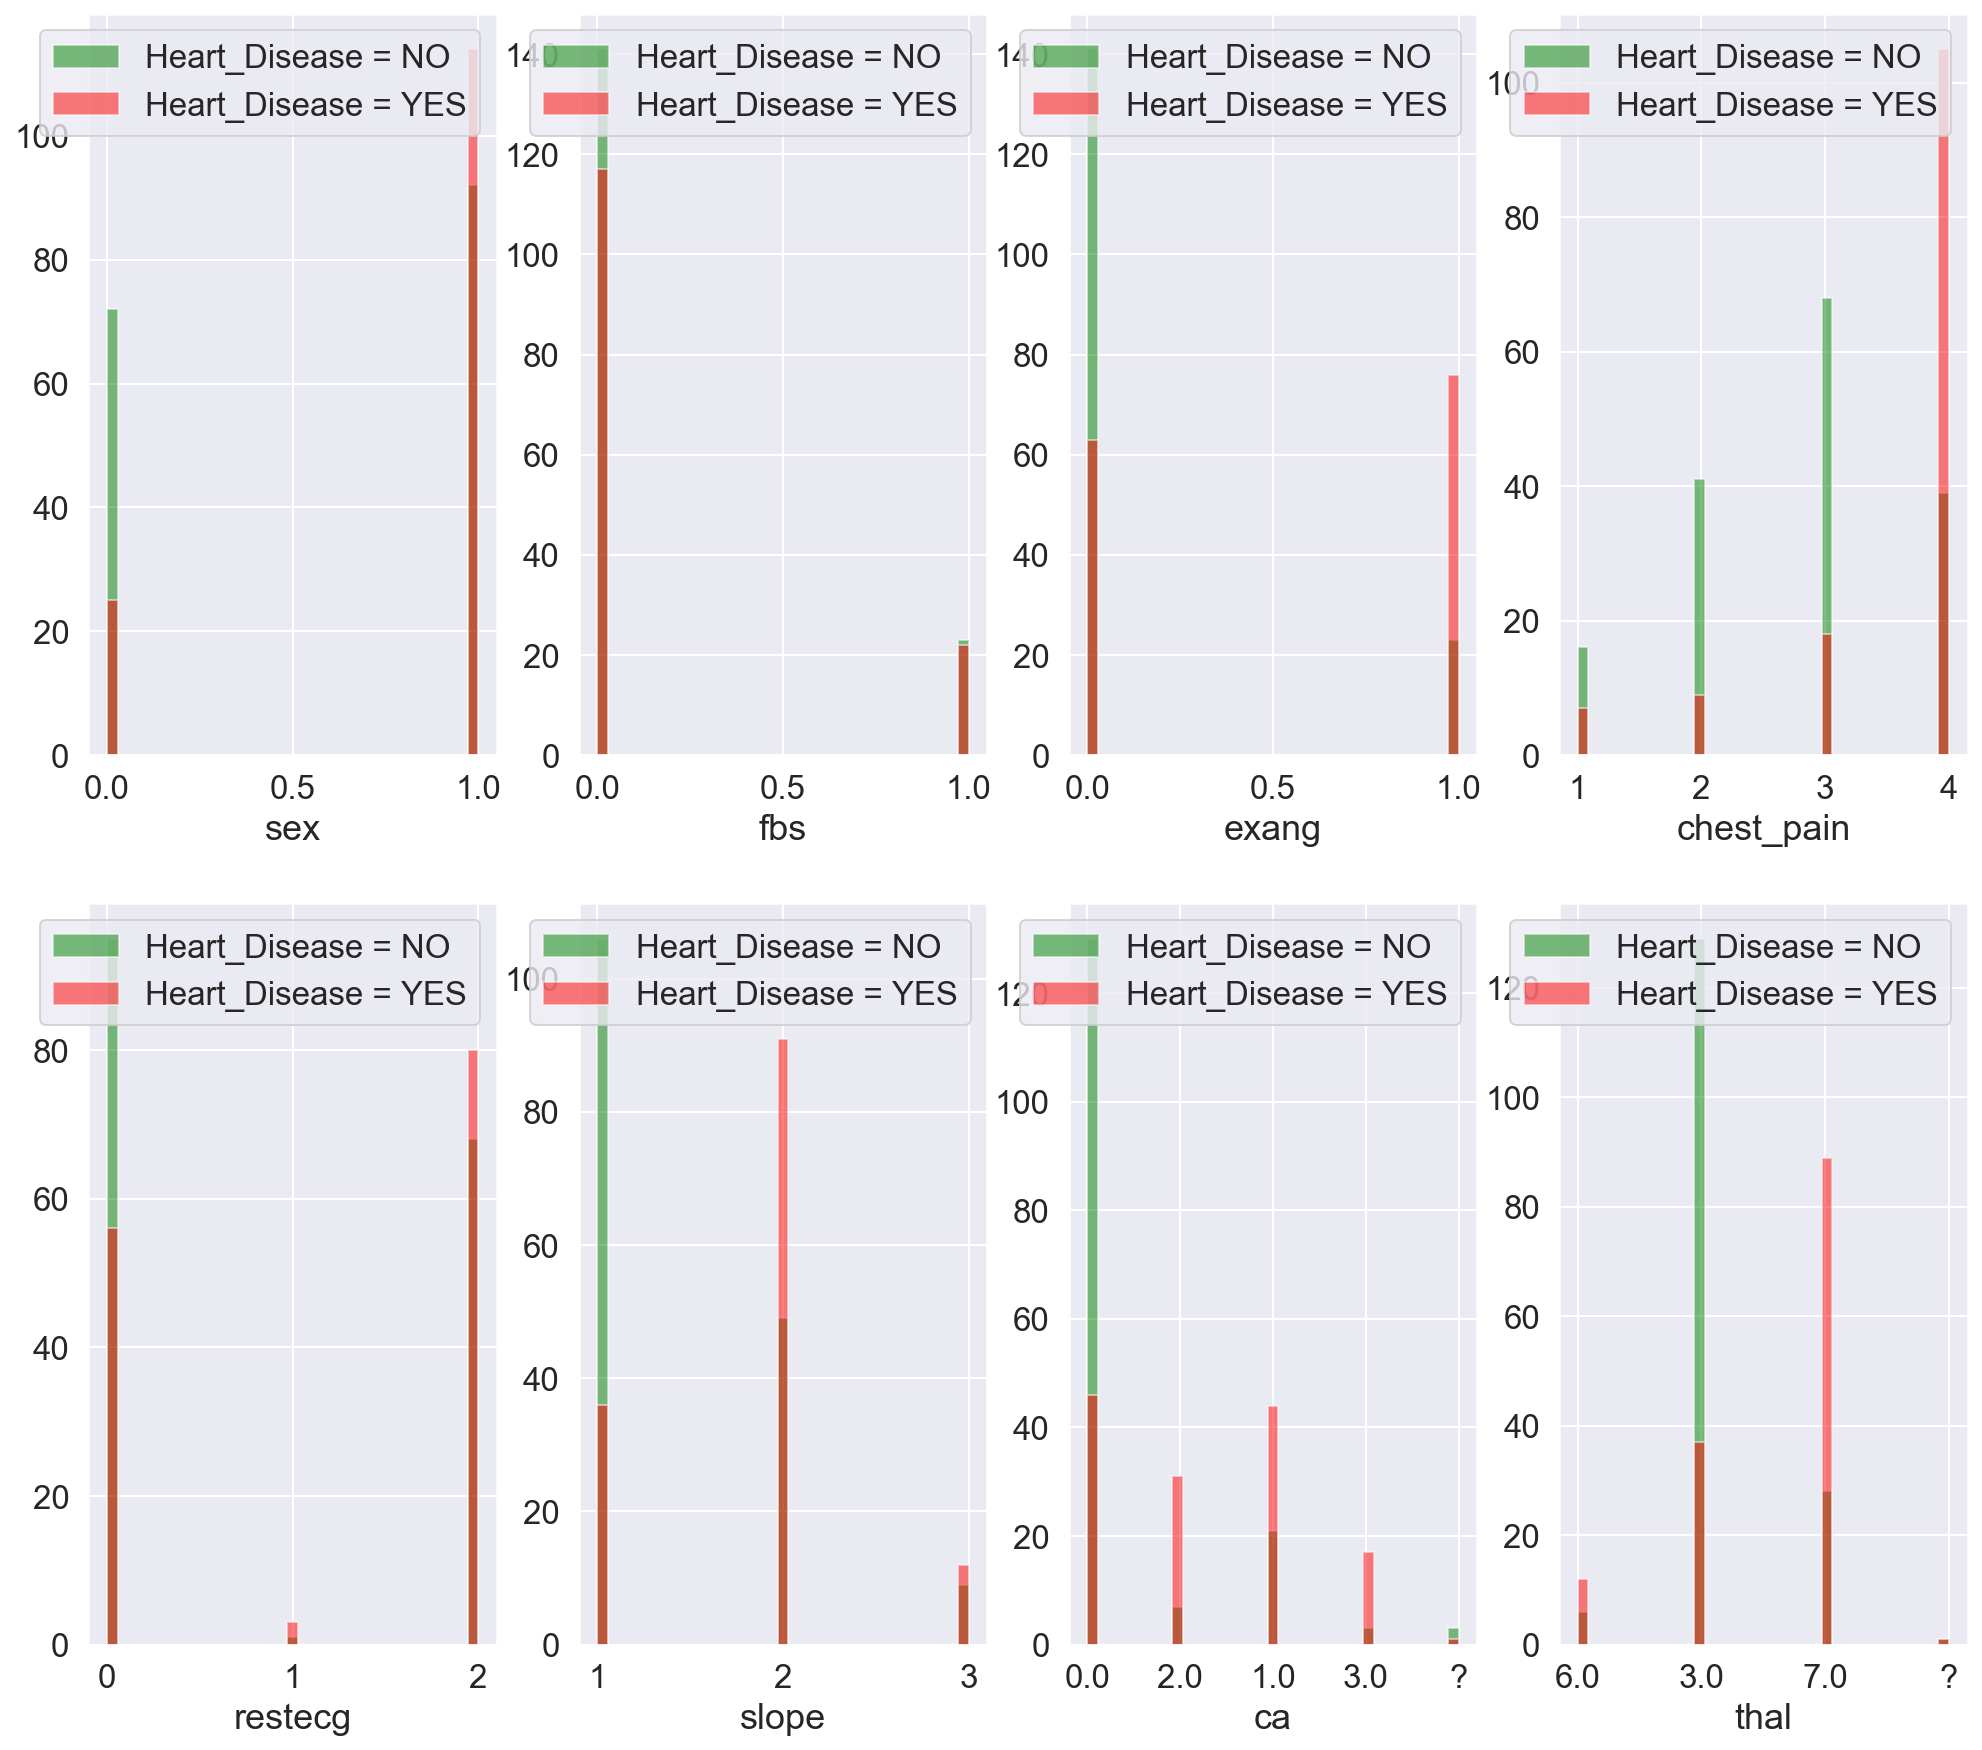

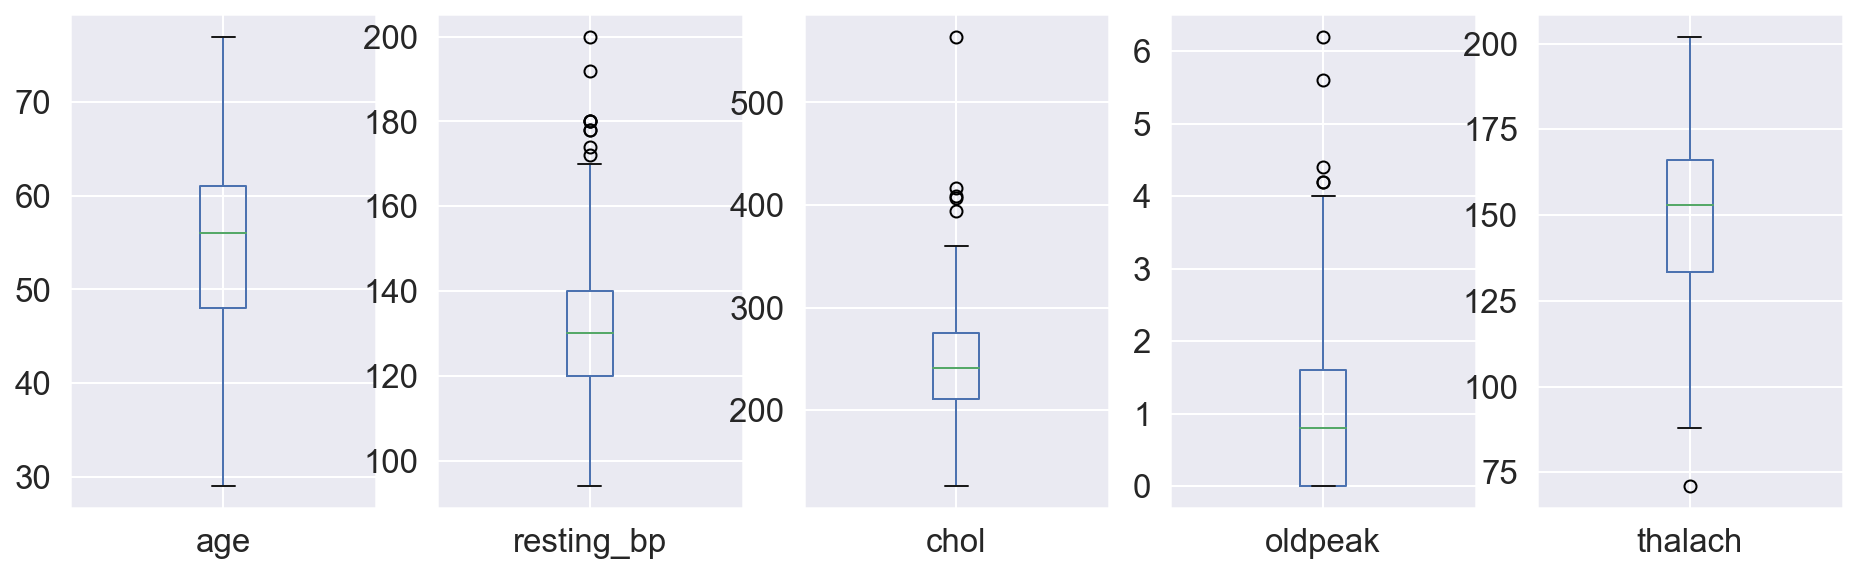

In [91]:
# Box plot and bar chart plotting to understand the features and identify any outliers

categorical_features, continuous_features = plotting(heartDF, target)

In [94]:
heartDF = DataCleaning(heartDF)
heartDF.head(2)

Checking for Nulls
--------------
age              0
sex              0
chest_pain       0
resting_bp       0
chol             0
fbs              0
restecg          0
thalach          0
exang            0
oldpeak          0
slope            0
ca               0
thal             0
heart_disease    0
dtype: int64
--------------
 
info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
age              297 non-null int64
sex              297 non-null int64
chest_pain       297 non-null int64
resting_bp       297 non-null int64
chol             297 non-null int64
fbs              297 non-null int64
restecg          297 non-null int64
thalach          297 non-null int64
exang            297 non-null int64
oldpeak          297 non-null float64
slope            297 non-null int64
ca               297 non-null float64
thal             297 non-null float64
heart_disease    297 non-null int64
dtypes: float64(3), int64(11)
memory usage: 34.8

,age,sex,chest_pain,resting_bp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1


In [ ]:
# Plotting after Data Clean up

# categorical_features, continuous_features = plotting(heartDF, target)

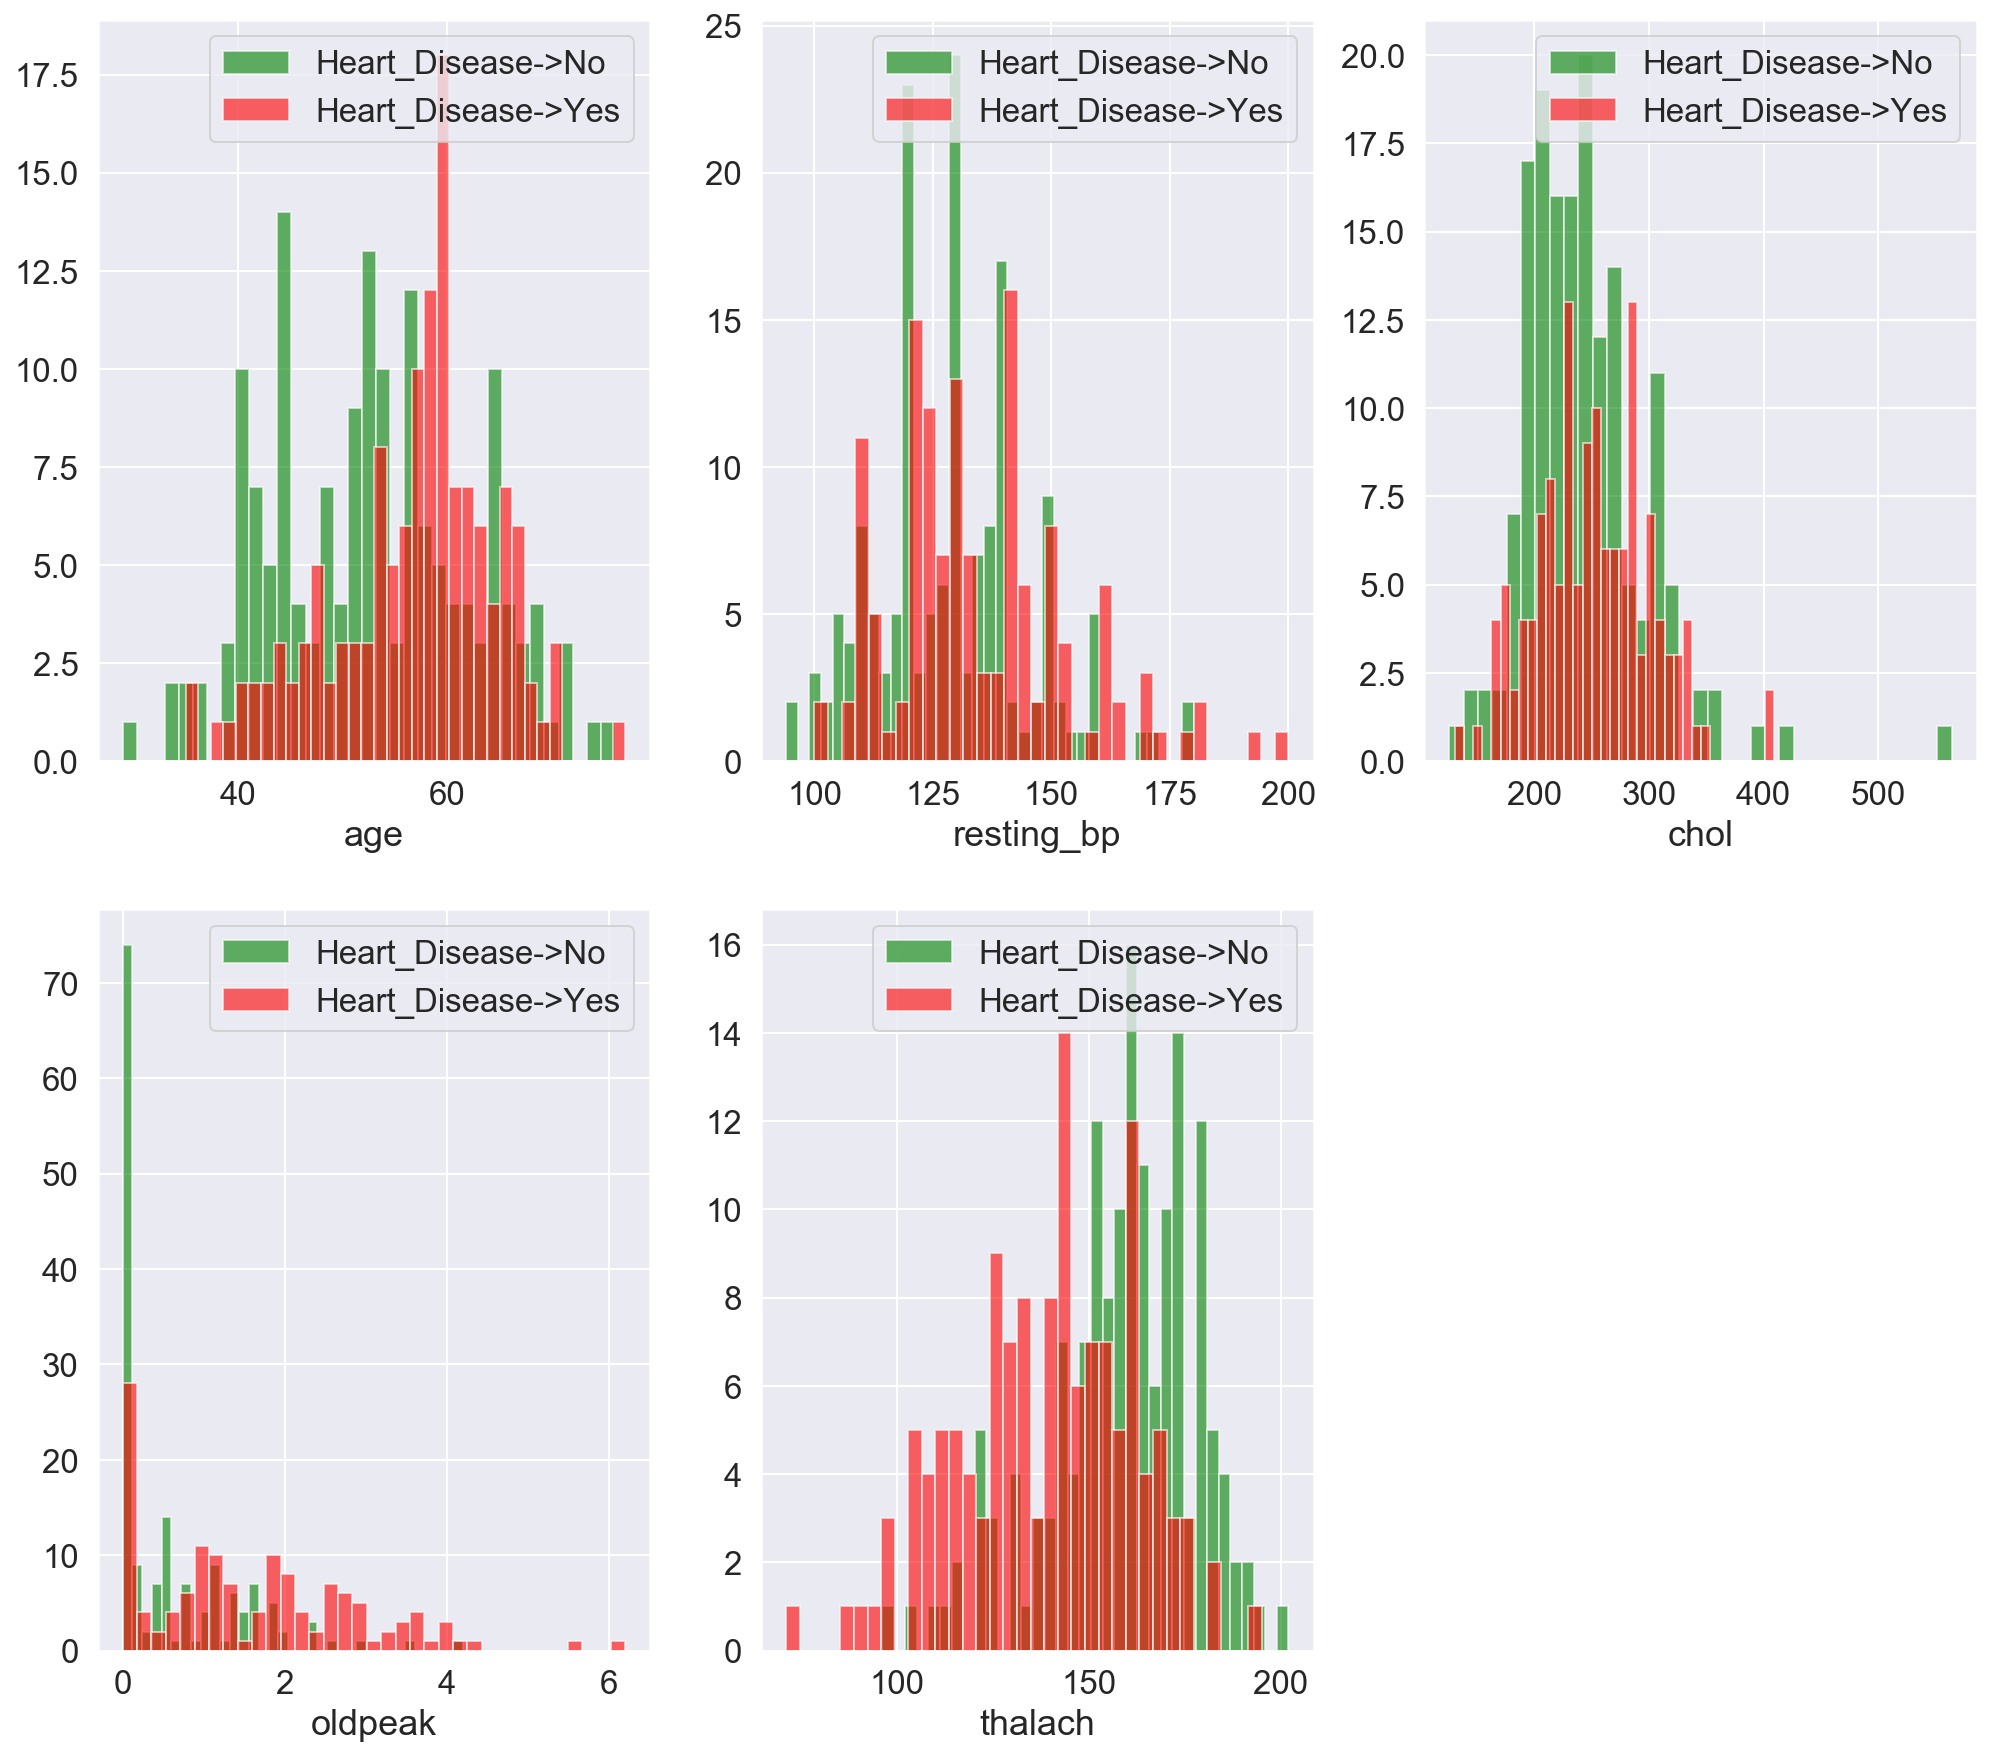

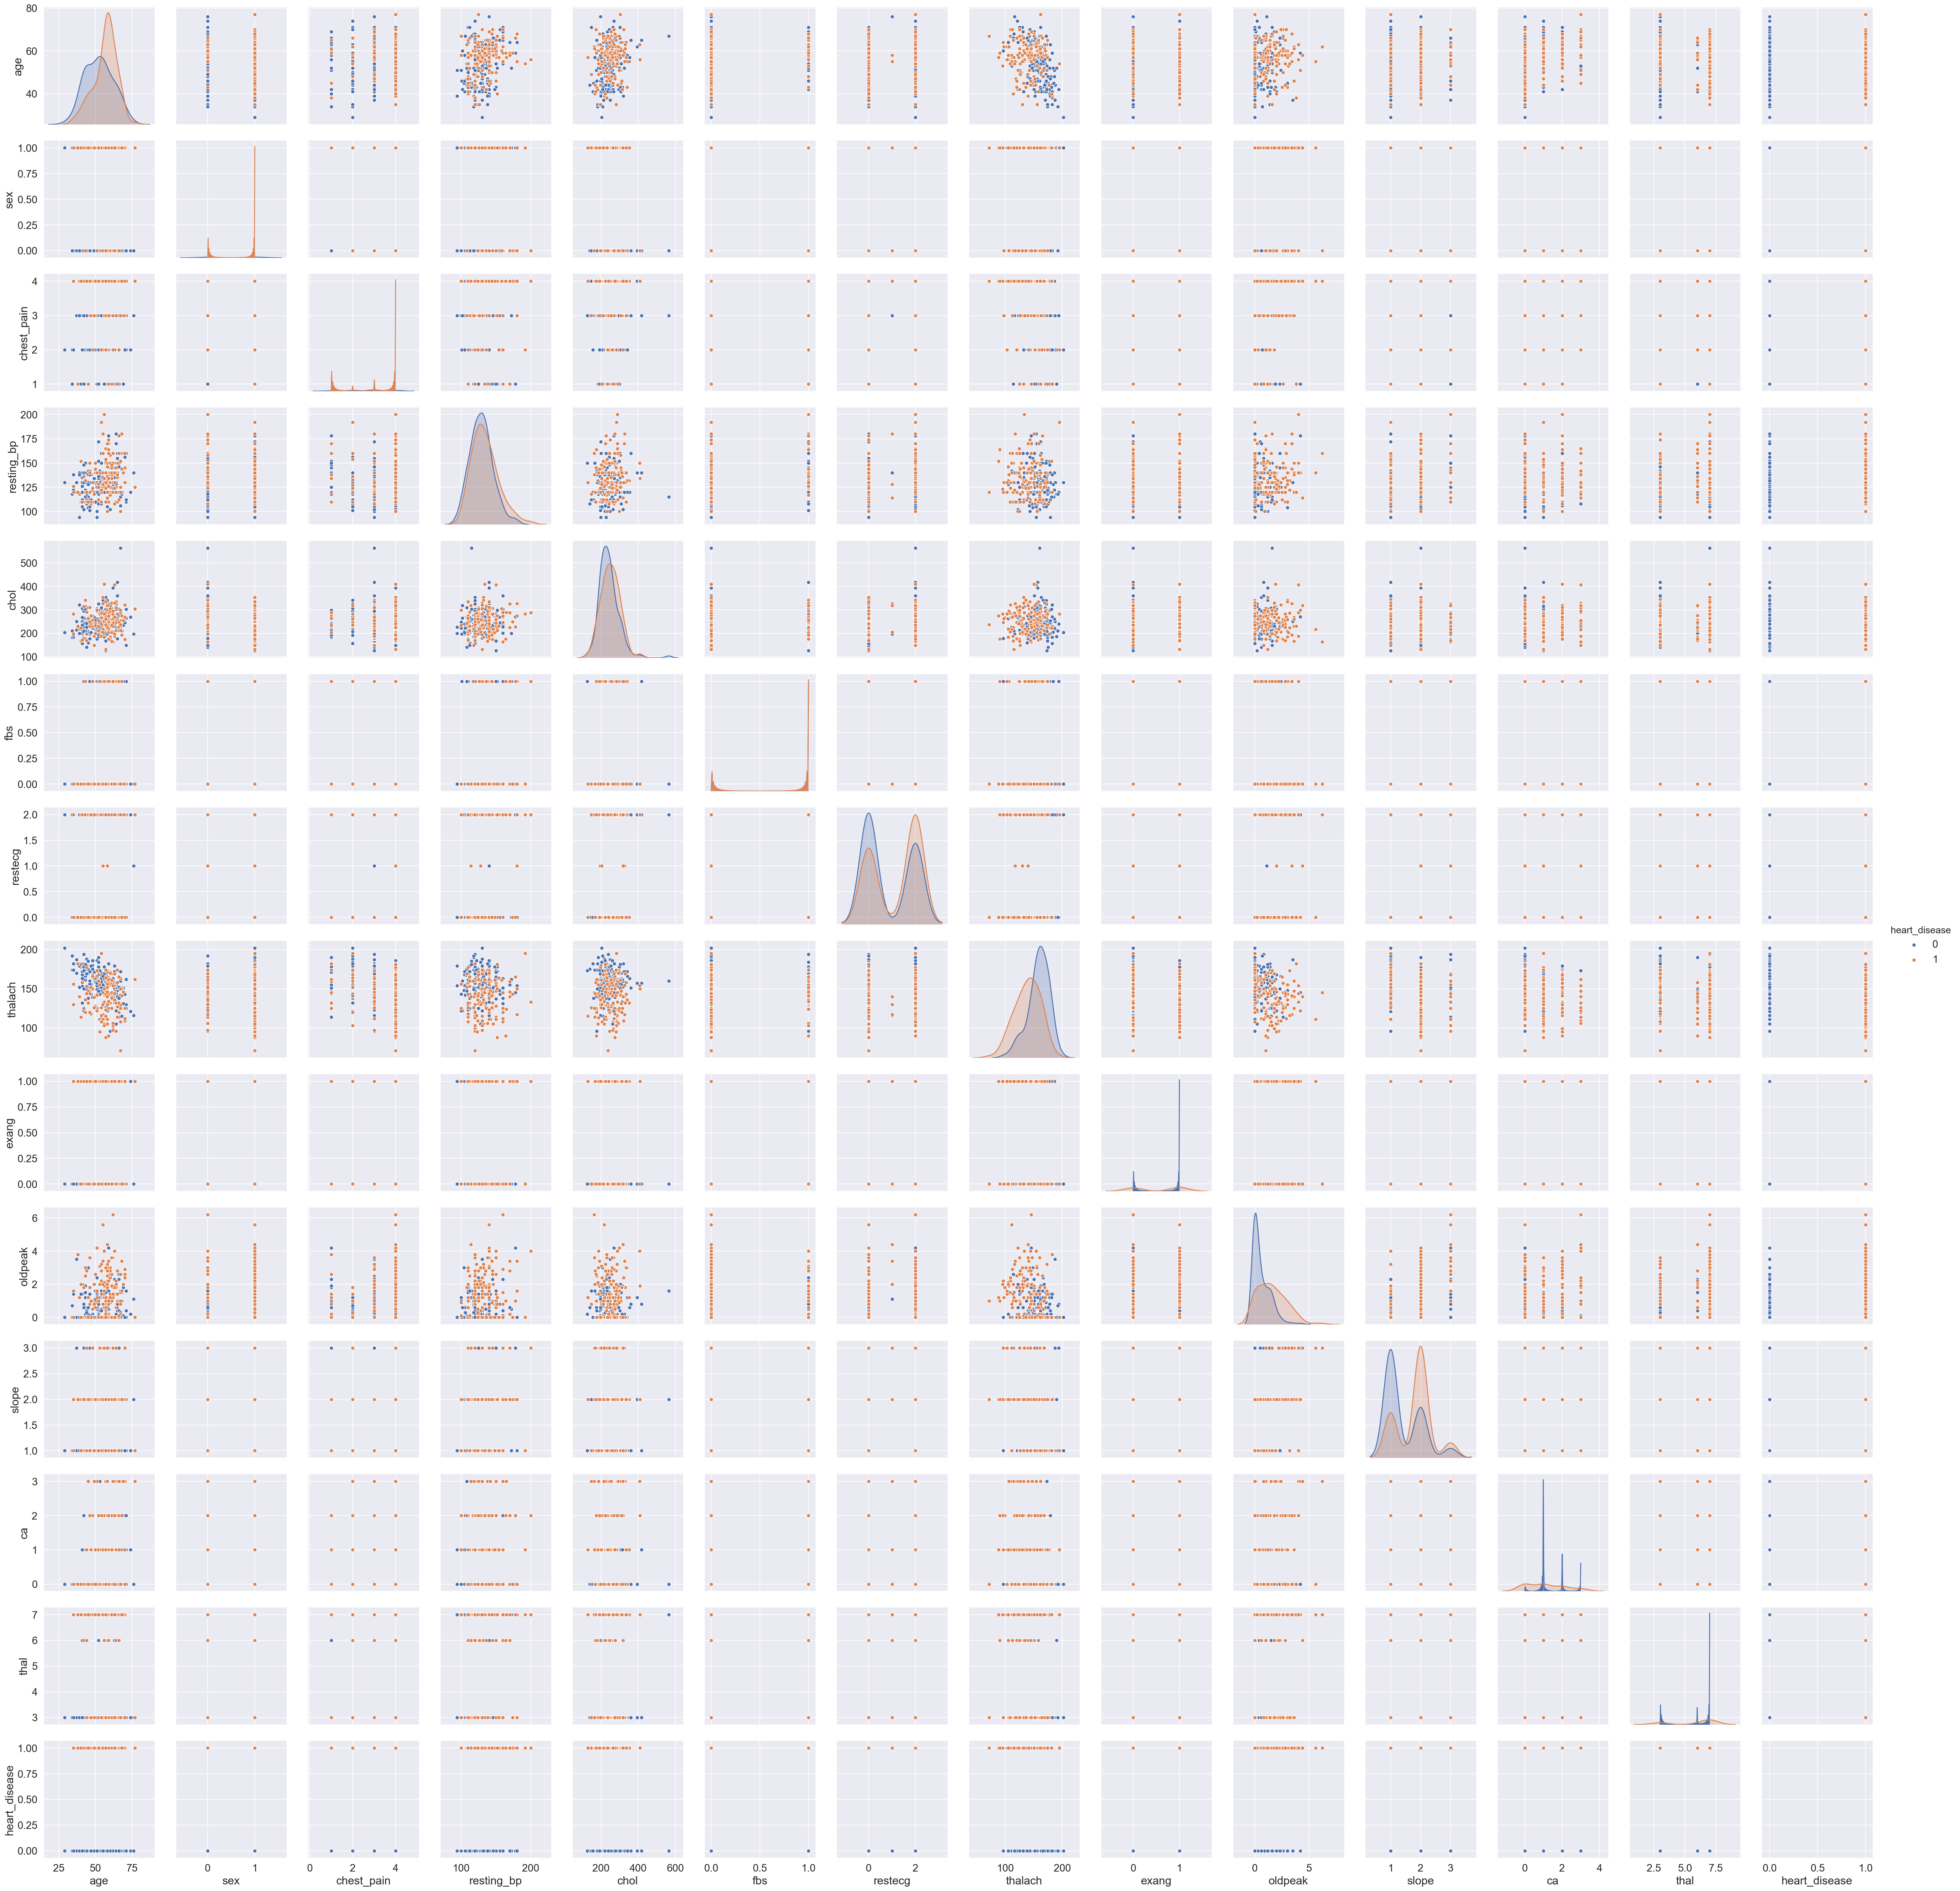

In [22]:
DataVisualizations(heartDF, target, categorical_features, continuous_features)

In [95]:
    
test_size = 0.2  # (80:20 train test split)
X_train, X_test, y_train, y_test, X_train_orig, X_test_orig, y_train_orig, y_test_orig = TrainTestSplit_Standardization(heartDF, target, test_size)

(237, 13)
(237,)
(60, 13)
(60,)


Plotting correlation
------------


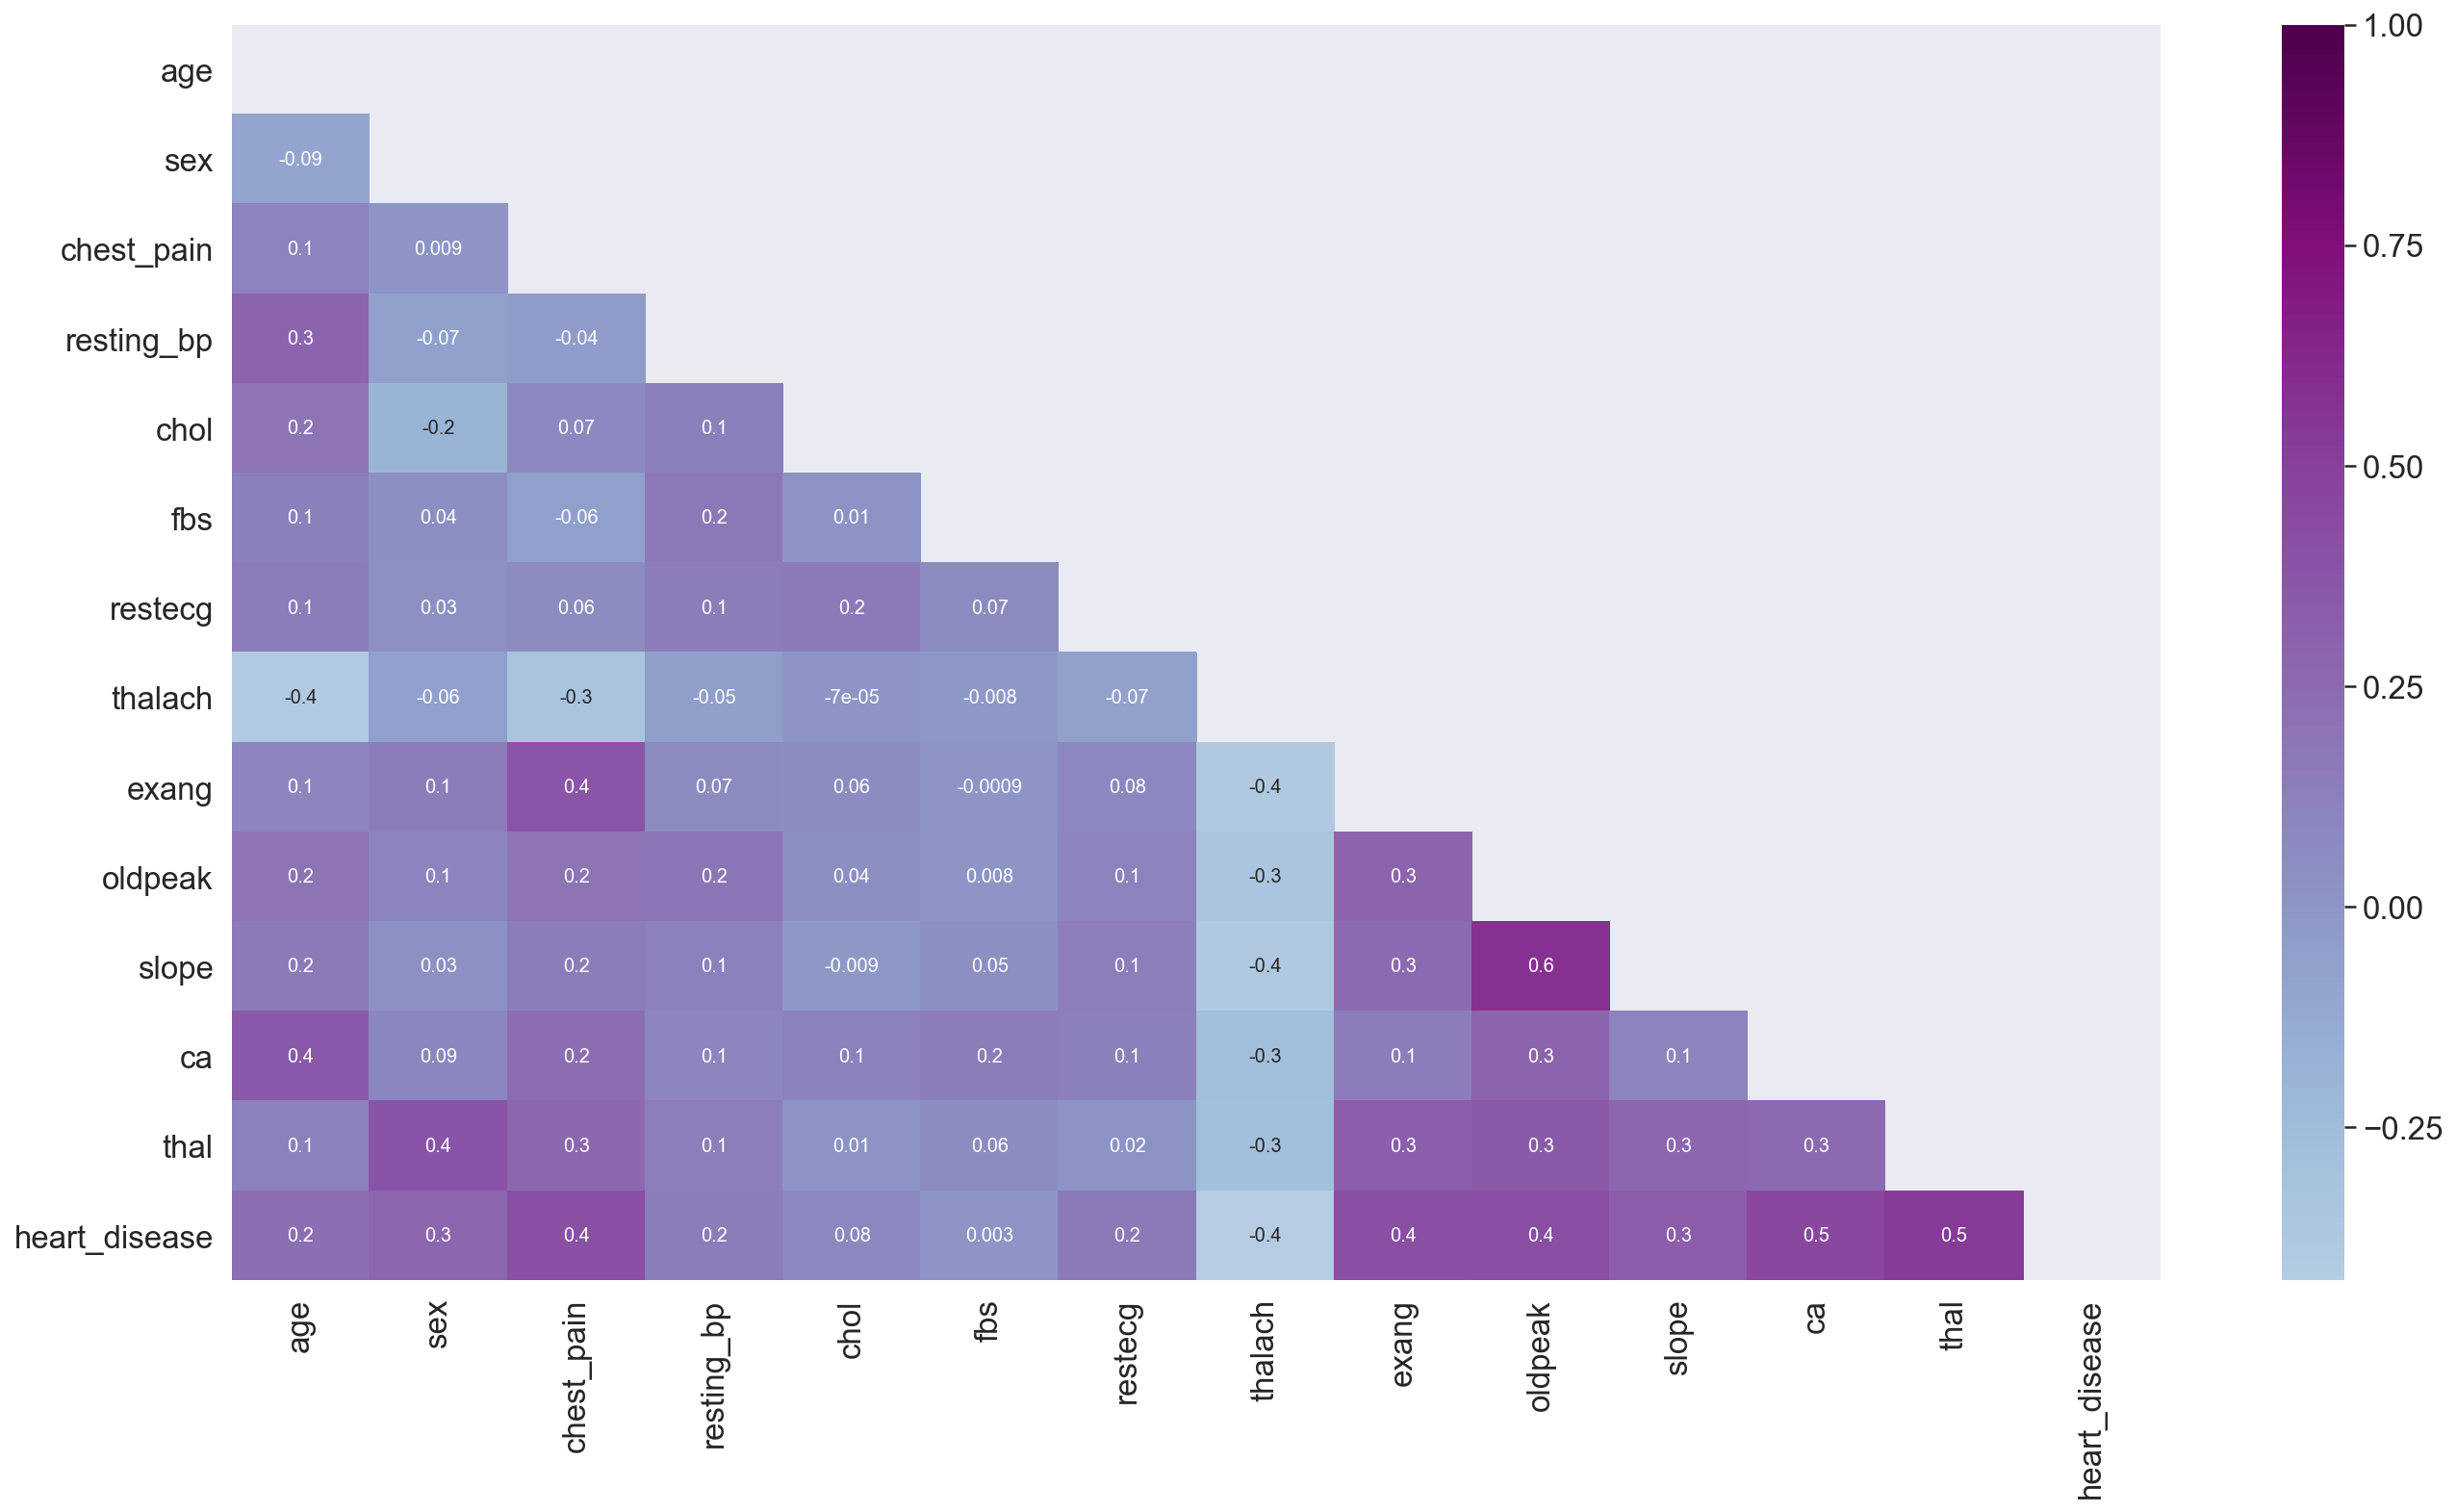

 
Plotting K-best features
------------
   Feature_Name      Score      p-values
11         thal  79.070439  1.621654e-16
6       oldpeak  57.359076  8.273064e-13
12      thalach  53.091175  4.798833e-12
1            ca  45.971704  9.610309e-11
4         exang  42.533594  4.212443e-10
2    chest_pain  34.707362  1.318613e-08
10        slope  31.419459  5.805408e-08
9           sex  26.541244  5.461514e-07
0           age  14.948340  1.430529e-04
8    resting_bp   7.557498  6.440428e-03
7       restecg   7.086514  8.302823e-03
3          chol   1.406136  2.368966e-01
 
Variation Inflation Factor
------------
         Features        VIF
3      resting_bp  60.917784
0             age  42.719806
7         thalach  36.776442
4            chol  26.158470
2      chest_pain  14.027296
10          slope  11.765073
12           thal  11.425012
13  heart_disease   3.964384
1             sex   3.923610
9         oldpeak   3.191434
11             ca   2.285916
6         restecg   2.188922
8       

In [24]:
featureSelection(heartDF, target, X_train, y_train)

#### Based on SelectKbest, VIF and correlation matrix, we drop few featues

In [25]:
X_train_new, X_test_new = selectedFeatures(X_train, X_test)

X_train:  (237, 10)
X_test:  (60, 10)


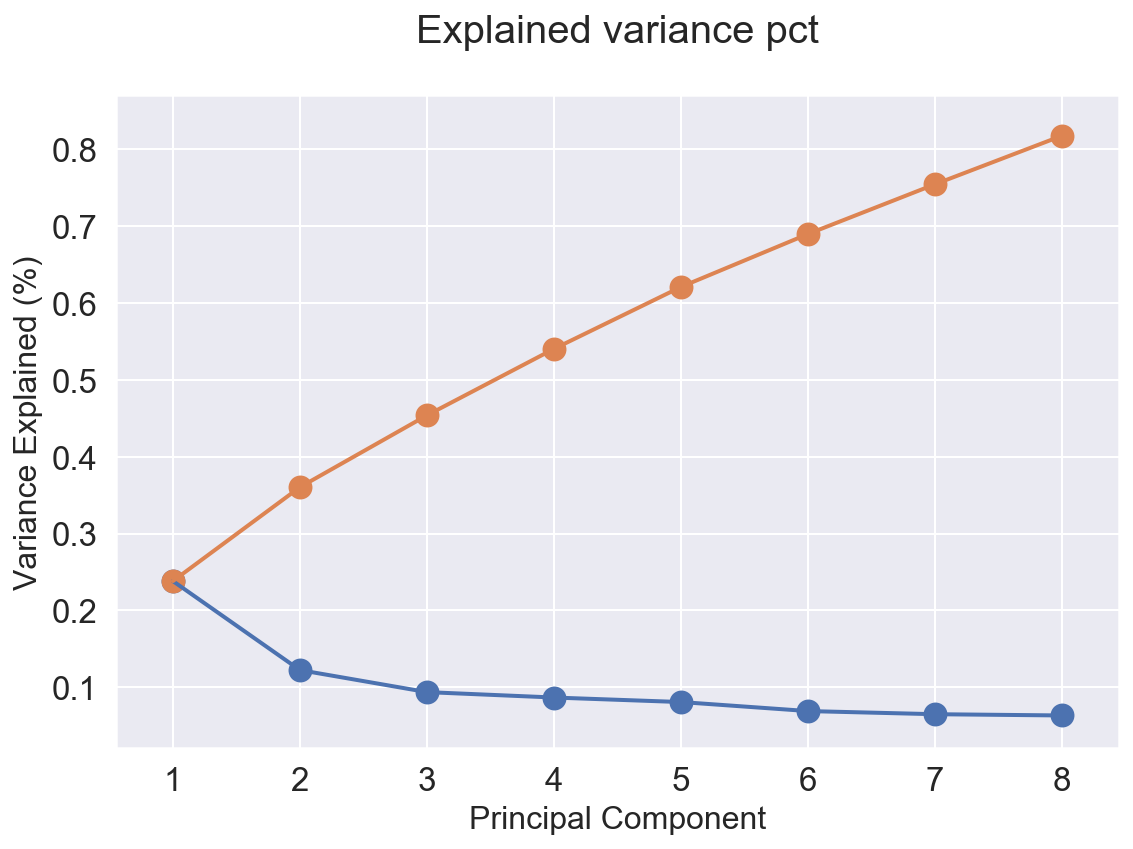

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8
age,0.284016,0.380244,0.087631,-0.137799,0.406934,0.037450,-0.373754,0.045189
ca,0.277134,0.078229,0.293170,-0.341174,0.298827,0.439642,0.200727,0.141239
chest_pain,0.288373,-0.105426,-0.406446,-0.368976,-0.036774,-0.056146,0.241792,-0.190716
chol,0.089518,0.454614,-0.084711,-0.292177,-0.292655,-0.216288,0.400007,0.429313
exang,0.339352,-0.154720,-0.251522,-0.144599,-0.247699,-0.286855,-0.108727,-0.315713
fbs,0.042734,0.146755,0.623315,-0.027451,0.075415,-0.368815,0.343629,-0.552323
oldpeak,0.406209,-0.043320,0.040045,0.409461,0.002394,0.158397,0.237618,0.213804
restecg,0.121077,0.285355,0.089232,-0.101326,-0.599894,0.556613,-0.151391,-0.330470
resting_bp,0.193128,0.416497,0.100068,0.246406,-0.194115,-0.339019,-0.441284,0.130502
sex,0.123844,-0.497512,0.412779,-0.177599,-0.248361,0.052117,-0.292825,0.169580


In [54]:
# PCA
PCA_df, X_train_pca, X_test_pca = PCA(X_train, X_test)
PCA_df.head(14)

### Base models with all features

In [27]:
n_splits = 5 # 5 fold cross validation

#base_classifiers

base_classifiers = []
base_classifiers.append(('LR', LogisticRegression()))
base_classifiers.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
base_classifiers.append(('SVM', SVC()))
base_classifiers.append(('DT', DecisionTreeClassifier()))
base_classifiers.append(('ADA_Boost', AdaBoostClassifier()))
base_classifiers.append(('Gradient_Boost', GradientBoostingClassifier()))

base_classifiers.append(('Bagging',BaggingClassifier( base_estimator=KNeighborsClassifier(n_neighbors=5),#LogisticRegression(max_iter=10000),
                                   n_estimators=100 )))
base_classifiers.append(('RF', RandomForestClassifier()))

fitted_classifiers = baseModelFitting(base_classifiers, n_splits, X_train, X_test, y_train, y_test)

Classifier:  LogisticRegression()
 
Classification report
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        32
           1       0.87      0.93      0.90        28

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60

 
Confusion Matrix
          Predicted_No  Predicted_Yes
True_No             28              4
True_Yes             2             26
-------------------------------------------
Classifier:  KNeighborsClassifier()
 
Classification report
              precision    recall  f1-score   support

           0       0.89      0.75      0.81        32
           1       0.76      0.89      0.82        28

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.83      0.82      0.82        60

 
Confusion Matrix
          Predicted_No  Predicte

### Base models with selected features (X_train_new, X_test_new)

In [28]:
n_splits = 5 # 5 fold cross validation

fitted_classifiers_selectedFeatures = baseModelFitting(base_classifiers, n_splits, X_train_new, X_test_new, y_train, y_test)

Classifier:  LogisticRegression()
 
Classification report
              precision    recall  f1-score   support

           0       0.93      0.84      0.89        32
           1       0.84      0.93      0.88        28

    accuracy                           0.88        60
   macro avg       0.88      0.89      0.88        60
weighted avg       0.89      0.88      0.88        60

 
Confusion Matrix
          Predicted_No  Predicted_Yes
True_No             27              5
True_Yes             2             26
-------------------------------------------
Classifier:  KNeighborsClassifier()
 
Classification report
              precision    recall  f1-score   support

           0       0.94      0.91      0.92        32
           1       0.90      0.93      0.91        28

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60

 
Confusion Matrix
          Predicted_No  Predicte

### Base models with PCA features (X_train_pca, X_test_pca)

In [29]:
n_splits = 5 # 5 fold cross validation

fitted_classifiers_PCA = baseModelFitting(base_classifiers, n_splits, X_train_pca, X_test_pca, y_train, y_test)

Classifier:  LogisticRegression()
 
Classification report
              precision    recall  f1-score   support

           0       0.96      0.84      0.90        32
           1       0.84      0.96      0.90        28

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.91      0.90      0.90        60

 
Confusion Matrix
          Predicted_No  Predicted_Yes
True_No             27              5
True_Yes             1             27
-------------------------------------------
Classifier:  KNeighborsClassifier()
 
Classification report
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        32
           1       0.77      0.82      0.79        28

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60

 
Confusion Matrix
          Predicted_No  Predicte

### Grid Searches

#### Grid search Params

In [30]:
lr_params = {'C': np.logspace(-4, 4, 5),
             'penalty': ['l1', 'l2'],
             'solver': ['liblinear'],
             'class_weight':['balanced', None, 'auto'],
             'fit_intercept': [True, False]}

knn_params = {
                'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
             }

DT_classifier_params = {
                        'max_depth': list(range(1, 5))+[None], #How many nodes deep can the decision tree go?
                        'criterion' :['gini', 'entropy'], # for classification
                        'max_features': [None, 'auto'],# 'sqrt', 'log2'],   #Is there a cutoff to the number of features to use?
                        'max_leaf_nodes': list(range(4, 5)), #How many leaves can be generated per tree?
                        'min_samples_split': [2, 5, 10],#, 20, 30, 50], #How many samples need to be included at a node, at a minimum?    
                        'min_samples_leaf': [1, 2],#, 3,4] #How many samples need to be included at a leaf, at a minimum?                          
                        'class_weight':['balanced', None, 'auto'],  # if not using SMOTE etc to balance the class 
                        'ccp_alpha': [0, 0.001, 0.005, 0.01] #Associate a cost with the number of terminal nodes, for pruing, less alpha means larget cost
                       
                        }

Bagging_params = {'n_estimators': [10, 40]#, #, 100], 
                 # 'max_leaf_nodes':[10, 15]#, 
                 # 'max_depth':[4, 5, 6],
                 # 'max_samples':[5, 50],#[np.linspace(0.5, 1.0, 3)],# is the number of samples to draw from X to train each base estimator
                 # 'max_features':[5, 8],# [np.linspace(0.5, 1.0, 3)], #range(int(3/4.*X.shape[1]), X.shape[1]+1), # is the number of features to draw from X to train each base estimator, can be given as absolute number or fraction.
                  #'bootsrap':[True], # whether SAMPLES are drawn with replacement
                 # 'bootstrap_features':[True],  # whether FEATURES are drawn with replacement
                 # 'oob_score':[True], # Whether to use out-of-bag samples to estimate the generalization error
                 # 'warm_start':[False] #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new ensemble
                 }


RF_params = {
                'n_estimators': [10, 100, 200],
                'max_features': ['auto'],#, 'sqrt', 'log2', None],   #Is there a cutoff to the number of features to use?
                'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)], #How many nodes deep can the decision tree go?
                'criterion' :['gini', 'entropy'], # for classification
                'max_leaf_nodes': list(range(1, 12, 2))+[None]#, #How many leaves can be generated per tree?
                #  'min_samples_split': [2, 5, 10, 20, 30, 50], #How many samples need to be included at a node, at a minimum?    
                 # 'min_samples_leaf': [1, 2, 3,4],#How many samples need to be included at a leaf, at a minimum?                          
                 # 'class_weight':['balanced', None, 'auto'],  # if not using SMOTE etc to balance the class 
                 # 'ccp_alpha': [0, 0.001, 0.005, 0.01], #Associate a cost with the number of terminal nodes, for pruing, less alpha means larget cost
                 # 'max_samples': [5, 10, 20],
                 # 'bootstrap': [True, False],
                 # 'oob_score':[True]
                }


ada_params = {'n_estimators': [50, 100, 200, 500],
              'base_estimator' : [DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3),
                                  DecisionTreeClassifier(max_depth=4)]}

gb_params = {'n_estimators': [200, 500, 1000],
            'learning_rate': [0.02, 0.05],
            'max_depth': [1, 2],
            'min_samples_leaf': [5,10],
            'min_samples_split': [5,10]} 


SVM_params = { 'C': [0.1, 1, 10, 100, 1000],#[np.logspace(-5, 2, 5)]#,  # regularization parameter
               'gamma': [1e-3, 1e-4], #['auto']#,#'auto_deprecated', 'scale', ],
               'kernel': ['rbf','linear']# ,'poly','sigmoid', 'precomputed']#, 
              } 

grid_search_params = [lr_params, knn_params, SVM_params, DT_classifier_params, 
                     ada_params, gb_params, Bagging_params, RF_params]
#grid_search_params

### Gridsearch with all features (X_train, X_test)

In [31]:
best_gs_classifiers = gridSearchModelFitting(base_classifiers, grid_search_params, n_splits, X_train, X_test, y_train, y_test)

Classifier:  LR
model cross val score: 0.822
model best score: 0.818
model test score: 0.883
----------------------
Classifier:  KNN
model cross val score: 0.814
model best score: 0.844
model test score: 0.867
----------------------
Classifier:  SVM
model cross val score: 0.810
model best score: 0.831
model test score: 0.883
----------------------
Classifier:  DT
model cross val score: 0.683
model best score: 0.772
model test score: 0.633
----------------------
Classifier:  ADA_Boost
model cross val score: 0.776
model best score: 0.776
model test score: 0.833
----------------------
Classifier:  Gradient_Boost
model cross val score: 0.806
model best score: 0.831
model test score: 0.850
----------------------
Classifier:  Bagging
model cross val score: 0.818
model best score: 0.827
model test score: 0.833
----------------------
Classifier:  RF
model cross val score: 0.810
model best score: 0.835
model test score: 0.933
----------------------


### Gridsearch with selected features (X_train_new, X_test_new)

In [32]:

best_gs_classifiers_sltd_features = gridSearchModelFitting(base_classifiers, grid_search_params, n_splits, X_train_new, X_test_new, y_train, y_test)

Classifier:  LR
model cross val score: 0.810
model best score: 0.827
model test score: 0.883
----------------------
Classifier:  KNN
model cross val score: 0.818
model best score: 0.831
model test score: 0.883
----------------------
Classifier:  SVM
model cross val score: 0.840
model best score: 0.844
model test score: 0.900
----------------------
Classifier:  DT
model cross val score: 0.713
model best score: 0.776
model test score: 0.867
----------------------
Classifier:  ADA_Boost
model cross val score: 0.742
model best score: 0.784
model test score: 0.817
----------------------
Classifier:  Gradient_Boost
model cross val score: 0.818
model best score: 0.831
model test score: 0.850
----------------------
Classifier:  Bagging
model cross val score: 0.797
model best score: 0.806
model test score: 0.900
----------------------
Classifier:  RF
model cross val score: 0.789
model best score: 0.835
model test score: 0.883
----------------------


### Gridsearch with PCA features (X_train_pca, X_test_pca)

In [33]:
# X_train_pca, X_test_pca,

best_gs_classifiers_pca = gridSearchModelFitting(base_classifiers, grid_search_params, n_splits, X_train_pca, X_test_pca, y_train, y_test)

Classifier:  LR
model cross val score: 0.810
model best score: 0.818
model test score: 0.883
----------------------
Classifier:  KNN
model cross val score: 0.806
model best score: 0.835
model test score: 0.867
----------------------
Classifier:  SVM
model cross val score: 0.814
model best score: 0.819
model test score: 0.883
----------------------
Classifier:  DT
model cross val score: 0.734
model best score: 0.797
model test score: 0.850
----------------------
Classifier:  ADA_Boost
model cross val score: 0.785
model best score: 0.814
model test score: 0.800
----------------------
Classifier:  Gradient_Boost
model cross val score: 0.806
model best score: 0.810
model test score: 0.883
----------------------
Classifier:  Bagging
model cross val score: 0.835
model best score: 0.831
model test score: 0.800
----------------------
Classifier:  RF
model cross val score: 0.801
model best score: 0.827
model test score: 0.833
----------------------


In [34]:
#best_gs_classifiers

### Printing Evaluation metrics only for the best model & features

In [117]:
# Classification report
print('Classification report')
predictions = best_gs_classifiers['RF']['Best Estimator'].predict(X_test)
print(classification_report(y_test, predictions))
            
print(' ')
print('Confusion Matrix')
            
labels=[0, 1]
confusion_mat = confusion_matrix(y_test, predictions, labels=labels)
            
confusion_mat = pd.DataFrame(confusion_mat,
columns=['Predicted_No', 'Predicted_Yes'],
index=  ['True_No', 'True_Yes'])
            
print(confusion_mat)
            

Classification report
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        32
           1       0.95      0.68      0.79        28

    accuracy                           0.83        60
   macro avg       0.86      0.82      0.83        60
weighted avg       0.86      0.83      0.83        60

 
Confusion Matrix
          Predicted_No  Predicted_Yes
True_No             31              1
True_Yes             9             19


In [36]:
# For plotting ROC and Precision-Recall curves

import scikitplot as skplt

from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

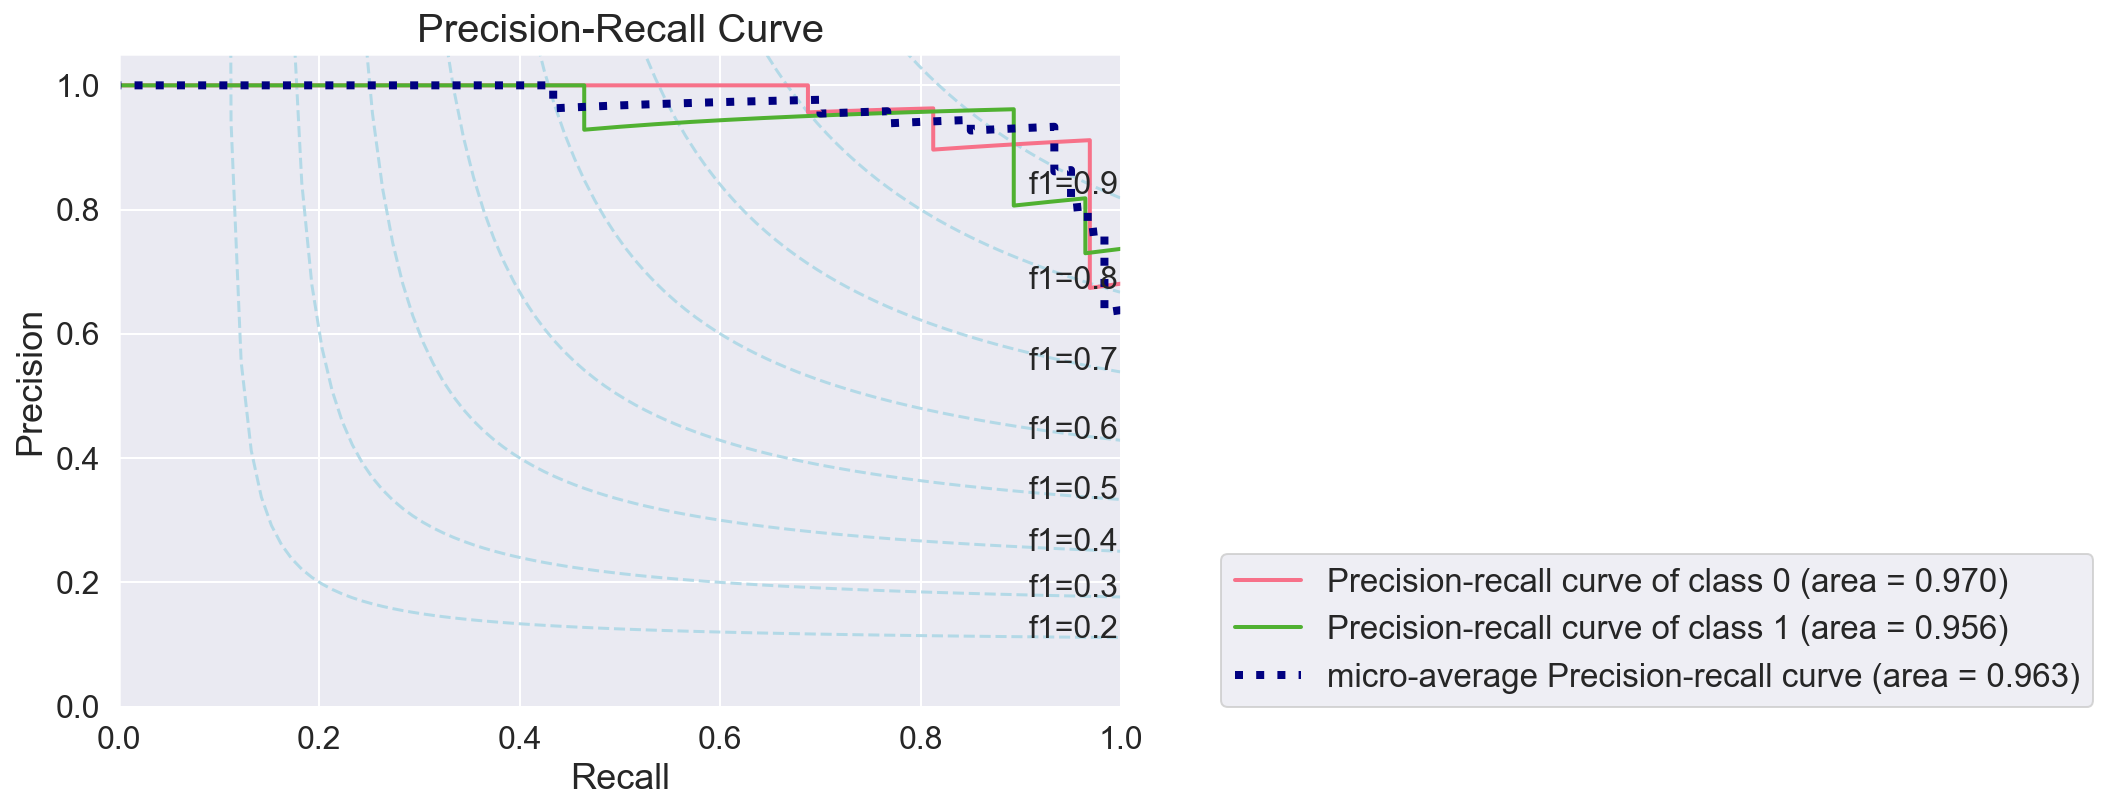

In [40]:
# Recall Precision plot

probabilities = best_gs_classifiers['RF']['Best Estimator'].predict_proba(X_test)

fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()


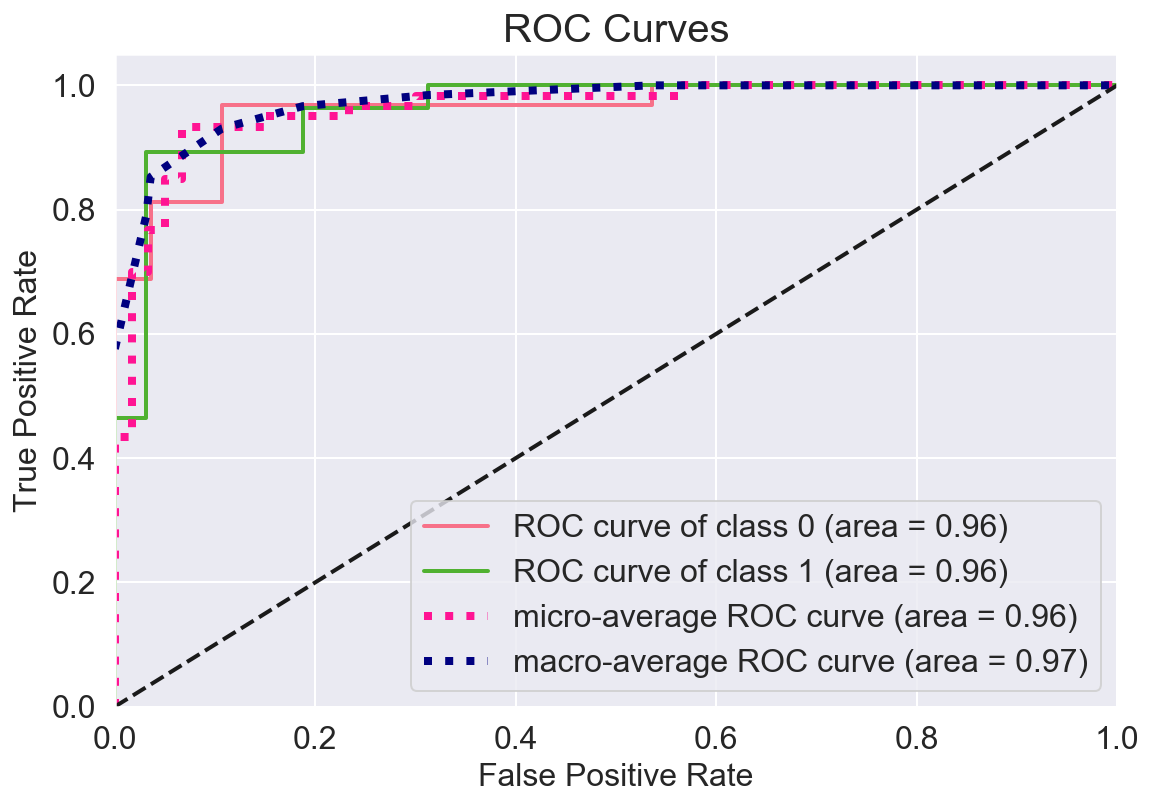

In [41]:
# AUC ROC plot

probabilities = best_gs_classifiers['RF']['Best Estimator'].predict_proba(X_test)

skplt.metrics.plot_roc(y_test, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap)
plt.show()

In [45]:
# Feature importance

feature_importance = best_gs_classifiers['RF']['Best Estimator'].feature_importances_ #coef_[0]
                  
feature_importanceDF = pd.DataFrame({'variable': X_train.columns,
                             'coef': feature_importance,
                             'abs_coef': np.abs(feature_importance), 
                            })
feature_importanceDF.sort_values(by='abs_coef', ascending=False).head(12)

,variable,coef,abs_coef
11,thal,0.148825,0.148825
6,oldpeak,0.145387,0.145387
2,chest_pain,0.133151,0.133151
12,thalach,0.116562,0.116562
1,ca,0.115625,0.115625
0,age,0.091754,0.091754
4,exang,0.060984,0.060984
9,sex,0.050033,0.050033
8,resting_bp,0.044887,0.044887
3,chol,0.041572,0.041572


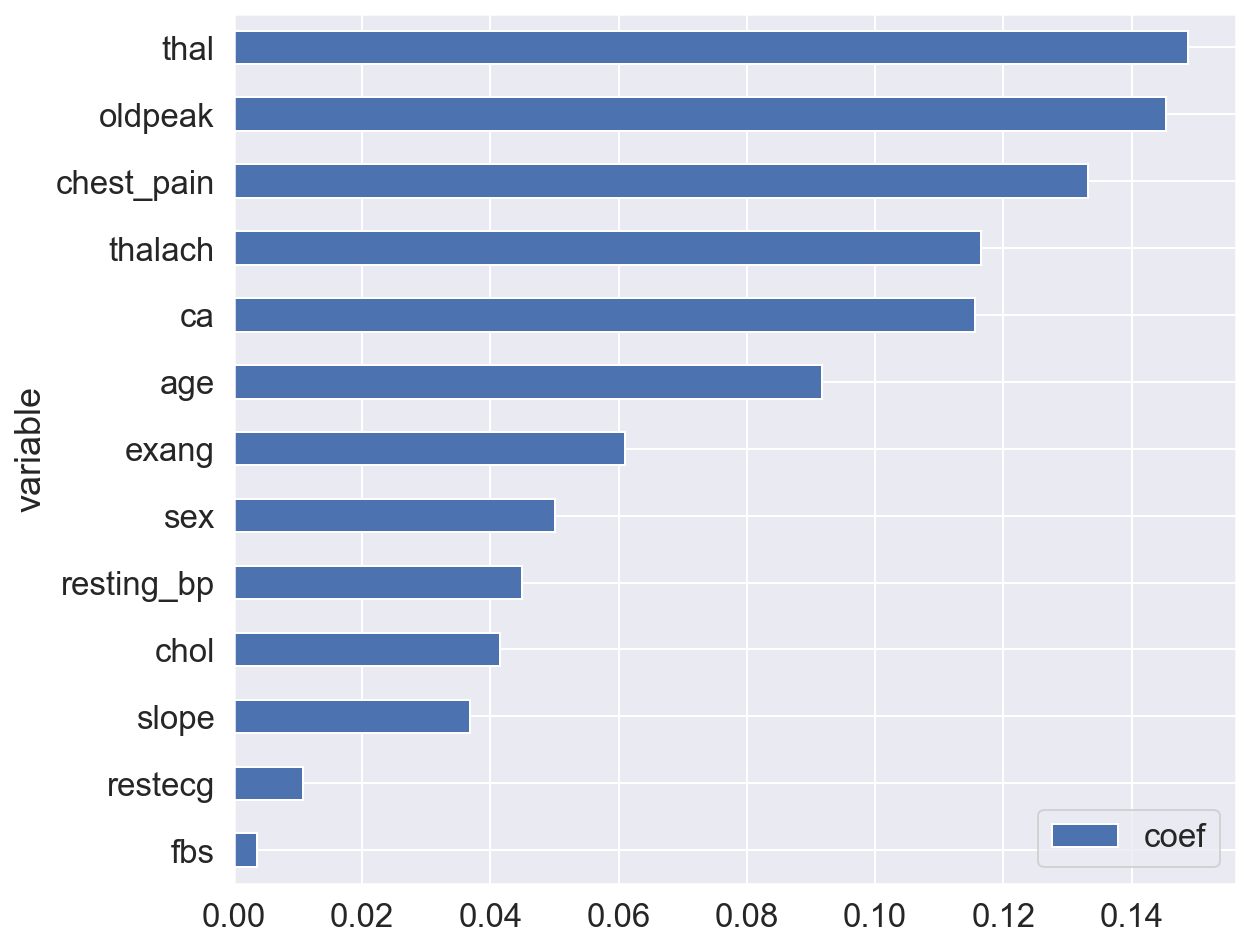

In [48]:
feature_importanceDF.sort_values(by='abs_coef', ascending=True).plot(kind='barh',  y='coef', x='variable',
                      color='b', figsize=(8, 8))
plt.show()